In [4]:
import pandas as pd
from biodata.delimited import DelimitedReader, DelimitedWriter
from collections import defaultdict, Counter
import pybedtools
import numpy as np
import subprocess
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statannotations.Annotator import Annotator
from biodatatools.utils.common import json_dump
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/ABC-Enhancer-Gene-Prediction/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Define candidate regions

In [5]:
cd $PROJECT_DIR_s

/NFS4/storage/yc2553/yc2553/projects/TRE_directionality/softwares/ABC-Enhancer-Gene-Prediction


## Basic parameters

In [6]:
outdir = f"{PROJECT_DIR_o}ABC/K562/"

In [6]:
chrom_sizes = "reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.tsv"
chrom_sizes_bed = "reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.bed"
with DelimitedWriter(chrom_sizes_bed) as dw:
	with DelimitedReader(chrom_sizes) as dr:
		for cols in dr:
			chrom, size = cols
			dw.write([chrom, 0, size])

In [7]:
# It's recommeded to resize to 500 bp to count reads in and around peaks (esp. e.g. H3K27ac signal is surrounding the peak)

extension = "250"

In [8]:
# For genome-wide analyses, 150K is recommended as a reasonable number because ENCODE analysis has previously estimated a mean of 205,109 DHSs per cell type, the majority of which are enhancers.

N = "150000"

## DNase peaks

In [9]:
dnase_bed = f"{PROJECT_DIR_r}ENCODE/ENCFF185XRG.bed.gz"
dnase_bam = f"{PROJECT_DIR_r}ENCODE/ENCFF205FNC.bam"

In [10]:
# Generate bam index

subprocess.run("samtools index " + dnase_bam, shell=True)

CompletedProcess(args='samtools index /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF205FNC.bam', returncode=0)

## Blocklist

In [11]:
# It's recommended to remove elements overlapping regions of the genome that have been observed to accumulate anomalous number of reads in epigenetic sequencing experiments 

blocklist = "reference/hg38/GRCh38_unified_blacklist.bed"

## Includelist

In [12]:
# It's recommended to force the inclusion of gene promoters in the set of candidate elements. Promoters are chromatin accessible sites, however sometimes the promoters of genes do not pass the threshold for top 150,000 strongest peaks. 

includelist = "reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed"

## Get candidate regions

In [13]:
commands = ["python", "workflow/scripts/makeCandidateRegions.py",
		    "--narrowPeak", dnase_bed,
		    "--accessibility", dnase_bam,
		    "--outDir", outdir,
		    "--chrom_sizes", chrom_sizes,
		    "--chrom_sizes_bed", chrom_sizes_bed,
		    "--regions_blocklist", blocklist,
		    "--regions_includelist", includelist,
		    "--peakExtendFromSummit", extension,
		    "--nStrongestPeaks", N
			]
subprocess.run(" ".join(commands), shell=True)

Running command: awk 'BEGIN {FS=OFS="\t"} (substr($1, length($1)) == "X" || substr($1, length($1)) == "Y") { $4 *= 2 } 1' /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.ENCFF205FNC.bam.Counts.bed > /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.ENCFF205FNC.bam.Counts.bed.tmp && mv /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.ENCFF205FNC.bam.Counts.bed.tmp /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.ENCFF205FNC.bam.Counts.bed
Running piped cmds: ['bedtools sort -i /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.ENCFF205FNC.bam.Counts.bed -faidx reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.tsv', 'bedtools merge -i stdin -c 4 -o max', 'sort -nr -k 4', 'head -n 150000', 'bedtools intersect -b stdin -a /fs/cbsuhy02/storage/yc2553/yc2553

CompletedProcess(args='python workflow/scripts/makeCandidateRegions.py --narrowPeak /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF185XRG.bed.gz --accessibility /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF205FNC.bam --outDir /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ --chrom_sizes reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.tsv --chrom_sizes_bed reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.bed --regions_blocklist reference/hg38/GRCh38_unified_blacklist.bed --regions_includelist reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed --peakExtendFromSummit 250 --nStrongestPeaks 150000', returncode=0)

In [11]:
# Check the output

candidate_regions = f"{outdir}ENCFF185XRG.bed.gz.candidateRegions.bed"
! wc -l $candidate_regions

137498 /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.candidateRegions.bed


In [8]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [16]:
# Check if this list covers PROcap elements we're interested for follow-up comparison

results = []
b1 = pybedtools.BedTool(candidate_regions)
for p, d in itertools.product(ps, ds):
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	# f: Minimum overlap required as a fraction of A
	overlaps = b2.intersect(b1, u=True, f=0.5)
	results.append([(p,d), len(b2), len(overlaps), round(len(overlaps)/len(b2),3)])
df = pd.DataFrame(results, columns=["Group", "No. total", "No. overlap with candidate regions", "Ratio"])
df

,Group,No. total,No. overlap with candidate regions,Ratio
0,"(divergent, distal)",8416,7818,0.929
1,"(divergent, proximal)",9026,8645,0.958
2,"(unidirectional, distal)",3557,3536,0.994
3,"(unidirectional, proximal)",1304,1300,0.997


# Run ABC model

In [17]:
# Generate bam index

H3K27ac_bams = [f"{PROJECT_DIR_r}ENCODE/ENCFF121RHF.bam",
			    f"{PROJECT_DIR_r}ENCODE/ENCFF907MNY.bam"
			   ]
for bam in H3K27ac_bams:
	subprocess.run("samtools index " + bam, shell=True)

In [18]:
H3K27ac_bams = ",".join(H3K27ac_bams)
acc = "DHS"
cell = "K562"
hic = f"{PROJECT_DIR_r}ENCODE/ENCFF621AIY.hic"

In [19]:
# Step 1: Estimate enhancer activity

commands = ["python", "workflow/scripts/run.neighborhoods.py",
		    "--candidate_enhancer_regions", candidate_regions,
		    "--genes", "reference/hg38/CollapsedGeneBounds.hg38.bed",
		    "--H3K27ac", H3K27ac_bams,
		    "--DHS", dnase_bam,
		    "--qnorm", "reference/EnhancersQNormRef.K562.txt",
		    "--chrom_sizes", "reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.tsv",
		    "--chrom_sizes_bed", "reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.bed",
		    "--ubiquitously_expressed_genes", "reference/UbiquitouslyExpressedGenes.txt",
		    "--cellType", cell,
		    "--outdir", outdir
			]
subprocess.run(" ".join(commands), shell=True)

Namespace(candidate_enhancer_regions='/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.candidateRegions.bed', outdir='/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/', genes='reference/hg38/CollapsedGeneBounds.hg38.bed', genes_for_class_assignment=None, ubiquitously_expressed_genes='reference/UbiquitouslyExpressedGenes.txt', gene_name_annotations='symbol', primary_gene_identifier='symbol', skip_gene_counts=False, H3K27ac='/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF121RHF.bam,/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF907MNY.bam', DHS='/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF205FNC.bam', ATAC='', default_accessibility_feature=None, expression_table='', qnorm='reference/EnhancersQNormRef.K562.txt', tss_slop_for_class_assignment=500, skip_rpkm_quantile=False, use_secondary_counting_

CompletedProcess(args='python workflow/scripts/run.neighborhoods.py --candidate_enhancer_regions /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ENCFF185XRG.bed.gz.candidateRegions.bed --genes reference/hg38/CollapsedGeneBounds.hg38.bed --H3K27ac /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF121RHF.bam,/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF907MNY.bam --DHS /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF205FNC.bam --qnorm reference/EnhancersQNormRef.K562.txt --chrom_sizes reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.tsv --chrom_sizes_bed reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.bed --ubiquitously_expressed_genes reference/UbiquitouslyExpressedGenes.txt --cellType K562 --outdir /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/', returncode=0)

In [20]:
# Step 2: Calculate ABC scores

commands = ["python", "workflow/scripts/predict.py",
		    "--enhancers", f"{outdir}/EnhancerList.txt",
		    "--genes", f"{outdir}/GeneList.txt",
		    "--chrom_sizes", "reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.tsv",
		    "--accessibility_feature", acc,
		    "--hic_file", hic,
		    "--hic_resolution", "5000",
		    "--hic_pseudocount_distance", "5000",
		    "--scale_hic_using_powerlaw",
		    "--hic_gamma", "1.024238616787792",
		    "--hic_scale", "5.9594510043736655",
		    "--cellType", cell,
		    "--outdir", outdir,
		    "--make_all_putative"
			]
subprocess.run(" ".join(commands), shell=True)

reading genes
reading enhancers
Making predictions for chromosome: chr1
Making putative predictions table...
Done. There are 1563031 putative enhancers for chromosome chr1
Elapsed time: 3.8090929985046387
Begin HiC
HiC added to predictions table. Elapsed time: 104.87137818336487
HiC Complete
Completed chromosome: chr1. Elapsed time: 109.68138885498047 

Making predictions for chromosome: chr10
Making putative predictions table...
Done. There are 385272 putative enhancers for chromosome chr10
Elapsed time: 0.2978534698486328
Begin HiC
HiC added to predictions table. Elapsed time: 35.687469482421875
HiC Complete
Completed chromosome: chr10. Elapsed time: 36.25765109062195 

Making predictions for chromosome: chr11
Making putative predictions table...
Done. There are 952699 putative enhancers for chromosome chr11
Elapsed time: 0.851670503616333
Begin HiC
HiC added to predictions table. Elapsed time: 44.955105781555176
HiC Complete
Completed chromosome: chr11. Elapsed time: 46.409180879592

CompletedProcess(args='python workflow/scripts/predict.py --enhancers /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//EnhancerList.txt --genes /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//GeneList.txt --chrom_sizes reference/hg38/GRCh38_EBV.no_alt.chrom.sizes.tsv --accessibility_feature DHS --hic_file /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF621AIY.hic --hic_resolution 5000 --hic_pseudocount_distance 5000 --scale_hic_using_powerlaw --hic_gamma 1.024238616787792 --hic_scale 5.9594510043736655 --cellType K562 --outdir /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562/ --make_all_putative', returncode=0)

# Get the threshold for ABC scores

In [ ]:
# To find the cutoff for ABC score, it's recommended to use a threshold that achieves 70% recall in their CRISPR benchmark
# https://github.com/EngreitzLab/CRISPR_comparison

In [259]:
# Modify the template "config.yml"
# conda activate snakemake
# cd $outdir/benchmark
# snakemake --use-conda -j1 --conda-frontend conda

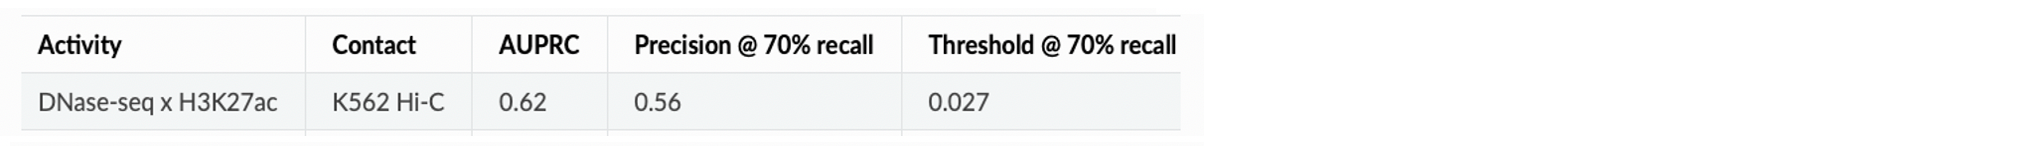

In [21]:
# The performance is comparable to the metrics as shown above (https://abc-enhancer-gene-prediction.readthedocs.io/en/latest/usage/methods.html#defining-candidate-elements)

inputfile = f"{outdir}benchmark/results/example/performance_summary.txt"
df = pd.read_table(inputfile)
df = df[["pred_name_long", "AUPRC", "PrecMinSens", "thresholdMinSens"]]
df.head()

,pred_name_long,AUPRC,PrecMinSens,thresholdMinSens
0,ABC,0.607002,0.544554,0.02532
1,Distance to TSS,0.435933,0.315789,-54.35000


In [22]:
threshold = 0.025

In [23]:
commands = ["python", "workflow/scripts/filter_predictions.py",
			"--output_tsv_file", f"{outdir}/EnhancerPredictionsFull.tsv",
			"--output_slim_tsv_file", f"{outdir}/EnhancerPredictions.tsv",
			"--output_bed_file", f"{outdir}/EnhancerPredictionsFull.bedpe",
			"--output_gene_stats_file", f"{outdir}/GenePredictionStats.tsv",
			"--pred_file", f"{outdir}/EnhancerPredictionsAllPutative.tsv.gz",
			"--pred_nonexpressed_file", f"{outdir}/EnhancerPredictionsAllPutativeNonExpressedGenes.tsv.gz",
			"--score_column", "ABC.Score",
			"--threshold", str(threshold),
			"--include_self_promoter", "False",
			"--only_expressed_genes", "True"
			]
subprocess.run(" ".join(commands), shell=True)

CompletedProcess(args='python workflow/scripts/filter_predictions.py --output_tsv_file /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//EnhancerPredictionsFull.tsv --output_slim_tsv_file /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//EnhancerPredictions.tsv --output_bed_file /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//EnhancerPredictionsFull.bedpe --output_gene_stats_file /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//GenePredictionStats.tsv --pred_file /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//EnhancerPredictionsAllPutative.tsv.gz --pred_nonexpressed_file /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/ABC/K562//EnhancerPredictionsAllPutativeNonExpressedGenes.tsv.gz --score_column ABC.Score --threshold 0.025 --include_self_promoter False --only_expressed_genes True', returncode=0)

In [17]:
inputfile = f"{outdir}EnhancerPredictions.tsv"
df_abc = pd.read_table(inputfile)
df_abc.head(2)

,chr,start,end,name,TargetGene,TargetGeneTSS,CellType,ABC.Score
0,chr1,778565,779411,intergenic|chr1:778565-779411,PLEKHN1,966496,K562,0.025339
1,chr1,778565,779411,intergenic|chr1:778565-779411,SAMD11,925740,K562,0.069367


In [18]:
e2g = defaultdict(set)
g2e = defaultdict(set)
for index, row in df_abc.iterrows():
	chrom, start, end, _, gene = row[:5]
	e2g[(chrom, str(start), str(end))].add(gene)
	g2e[gene].add((chrom, str(start), str(end)))

In [19]:
# The ABC model typically predicts on average ~3 distal enhancers per expressed gene. If you run the model on a cell type and find a large deviation from this number (say <2 or >5) this may mean the ABC model is not well calibrated in the cell type. 

len(e2g), len(g2e), np.mean([len(g2e[g]) for g in g2e])

(25276, 13397, 3.2689408076435025)

# G-E mapping

## Link PROcap elements to target genes

In [9]:
d = "distal"
es = {}
for p in ps:
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	es[p] = [tuple(i.fields[:3]) for i in b]

In [12]:
# Assign PROcap element to a DNase peak (>50% TRE length)

mapping_all = {}
mapping_rev = defaultdict(set)
b1 = pybedtools.BedTool(candidate_regions)
for p in ps:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	overlap = b2.intersect(b1, wao=True, f=0.5)
	for i in overlap:
		if int(i.fields[-1]) > 0:
			mapping_all[tuple(i.fields[:3])] = tuple(i.fields[-4:-1])
			mapping_rev[tuple(i.fields[-4:-1])].add((tuple(i.fields[:3]), p))

In [13]:
len(mapping_rev), len([k for k in mapping_rev if len(mapping_rev[k]) > 1]), sum([len(mapping_rev[k]) for k in mapping_rev if len(mapping_rev[k]) > 1])

(11238, 114, 230)

In [14]:
# If > 1 TREs overlap with one ABC element, remove all of them

mapping = {}
for e in mapping_all:
	chrom, start, end = mapping_all[e]
	if len(mapping_rev[(chrom, start, end)]) == 1:
		mapping[e] = mapping_all[e]

In [20]:
ns = defaultdict(list)
genes = defaultdict(set)
for p in ps:
	for e in es[p]:
		if e in mapping:
			ns[p].append(len(e2g[mapping[e]]))
			if len(e2g[mapping[e]]) > 0:
				genes[p] |= e2g[mapping[e]]

In [21]:
genes2 = {
		"Shared": list(set(genes[ps[0]]) & set(genes[ps[1]])),
		ps[0].capitalize(): [g for g in genes[ps[0]] if g not in genes[ps[1]]],
		ps[1].capitalize(): [g for g in genes[ps[1]] if g not in genes[ps[0]]]
		}

In [22]:
for k in genes2:
	print(k, len(genes2[k]))

Shared 858
Divergent 5265
Unidirectional 923


In [23]:
json_dump(f"{outdir}procap_genes.json", genes2)

## No. genes per enhancer

In [24]:
limit = 5
counts = {p: Counter(ns[p]) for p in ps}
# Aggregate counts below the limit and sum others
aggregated_counts = {p: defaultdict(int) for p in ps}
for p in ps:
	for k, v in counts[p].items():
		if k < limit:
			aggregated_counts[p][k] = v
		else:
			aggregated_counts[p][limit] += v

results = []
for p in ps:
	for key, value in aggregated_counts[p].items():
		results.append([p.capitalize(), key, value/len(ns[p])*100])
df_perc = pd.DataFrame(results, columns=["group", "category", "percentage"])	

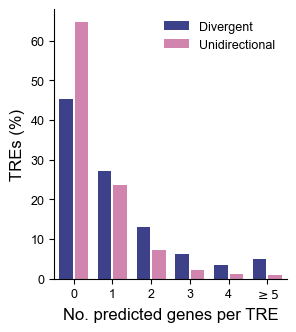

In [25]:
fig, ax = plt.subplots(figsize=(3,3.5))

colors = ["#313695", "#de77ae"]
g = sns.barplot(data=df_perc, hue="group", x="category", y="percentage", palette=colors, ax=ax)
		
def change_width(ax, new_value) :
	for patch in ax.patches :
		current_width = patch.get_width()
		diff = current_width - new_value
		patch.set_width(new_value)
		patch.set_x(patch.get_x() + diff * .5)
		
change_width(ax, .35)

g.spines[["right", "top"]].set_visible(False)
g.legend(loc="upper right", fontsize=sfontsize, frameon=False)

g.set_ylabel("TREs (%)", fontsize=bfontsize)
g.set_xlabel("No. predicted genes per TRE", fontsize=bfontsize)
g.set_xticks([n for n in range(limit+1)])
g.set_xticklabels([n for n in range(limit)] + ["$\geq " + str(limit) + "$"])
g.tick_params(labelsize=sfontsize)

outputfile = f"{PROJECT_DIR_o}figures/Fig3b.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)

## ABC score decomposition

In [26]:
# https://docs.google.com/spreadsheets/d/1UfoVXoCxUpMNPfGypvIum1-RvS07928grsieiaPX67I/edit#gid=972400588

inputfile = f"{outdir}EnhancerPredictionsAllPutative.tsv.gz"
df = pd.read_table(inputfile)
scores = {}
for index, row in df.iterrows():
	chrom, start, end = row[:3]
	dhs, h3k27, hic = row["normalized_dhs_enh"], row["normalized_h3k27ac_enh"], row["hic_contact_pl_scaled_adj"]
	scores.setdefault((chrom, str(start), str(end)), [dhs, h3k27, []])[2].append(hic)

In [27]:
results = []
for p in ps:
	for e in es[p]:
		if e in mapping:
			score_data = scores[mapping[e]]
			results.extend([
				[p.capitalize(), score_data[0], "DNase"],
				[p.capitalize(), score_data[1], "H3K27ac"],
				[p.capitalize(), np.mean(score_data[2]), "Avg HiC contact"]
			])
df_scores = pd.DataFrame(results, columns=["group", "score", "type"])

In [ ]:
ts = ["DNase", "H3K27ac", "Avg HiC contact"]

fig, ax = plt.subplots(1,len(ts),figsize=(6.5,2.5))

for t in ts:
	col = ts.index(t)
	hue_plot_params = {
				"data": df_scores[df_scores["type"]==t],
				"x": "group",
				"y": "score",
				"palette": ["#313695", "#de77ae"],
				"hue": "group",
				"legend": False,
				"showfliers": False
			}
	g = sns.boxplot(ax=ax[col], **hue_plot_params)
	g.spines[["right", "top"]].set_visible(False)

	g.set_ylabel(t, fontsize=bfontsize)
	g.tick_params(axis='y', labelsize=sfontsize)
	
	g.set_xlabel("")
	g.tick_params(axis='x', rotation=30, labelsize=bfontsize)

	annotator = Annotator(g, [["Divergent", "Unidirectional"]], **hue_plot_params)
	annotator.configure(test="Mann-Whitney", comparisons_correction="BH", text_offset=0, text_format="star", verbose=False, loc="outside")
	_, results = annotator.apply_and_annotate()
fig.subplots_adjust(wspace=0.7)

outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig7a.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)